In [2]:
from simformer import *
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np
import torch

%matplotlib inline

In [3]:
# Load data
x = np.load("data/x.npy")
theta = np.load("data/theta.npy")

data = torch.tensor(np.concatenate([theta, x], axis=1), dtype=torch.float32)

In [4]:
# Define beta schedule
T = 300

simformer = Simformer(T)

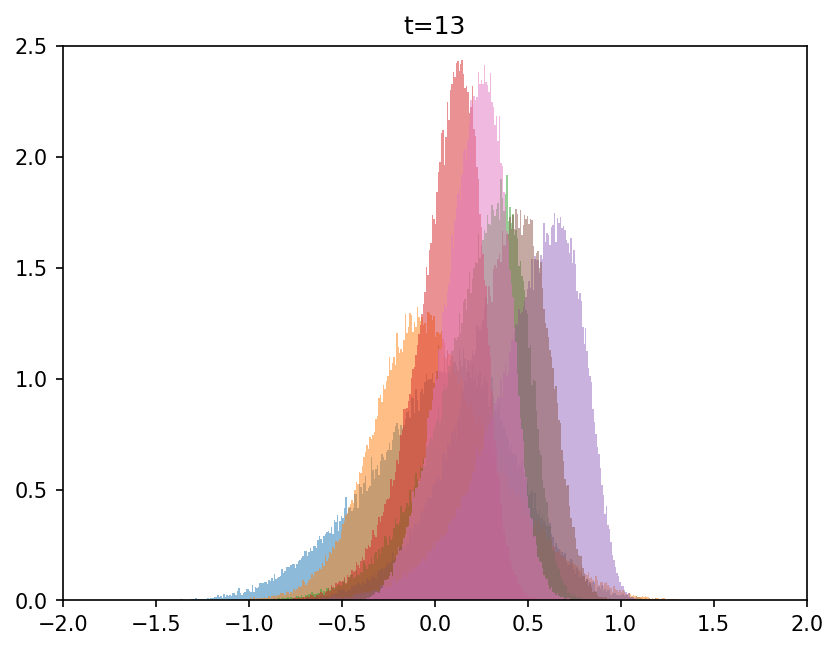

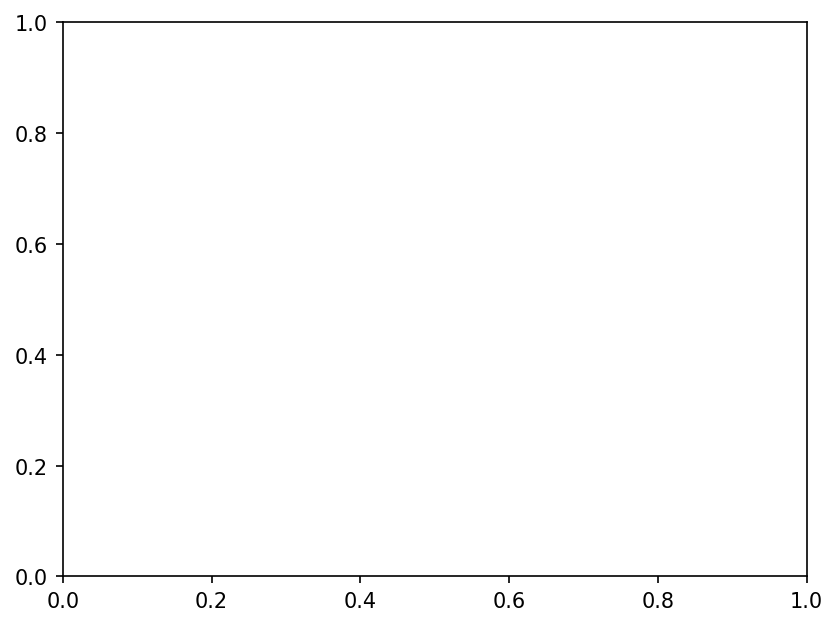

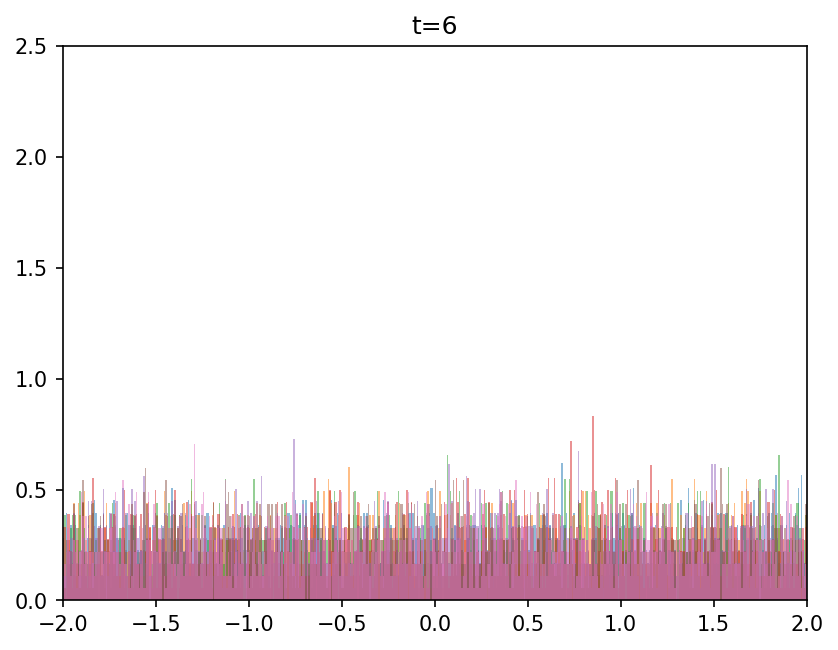

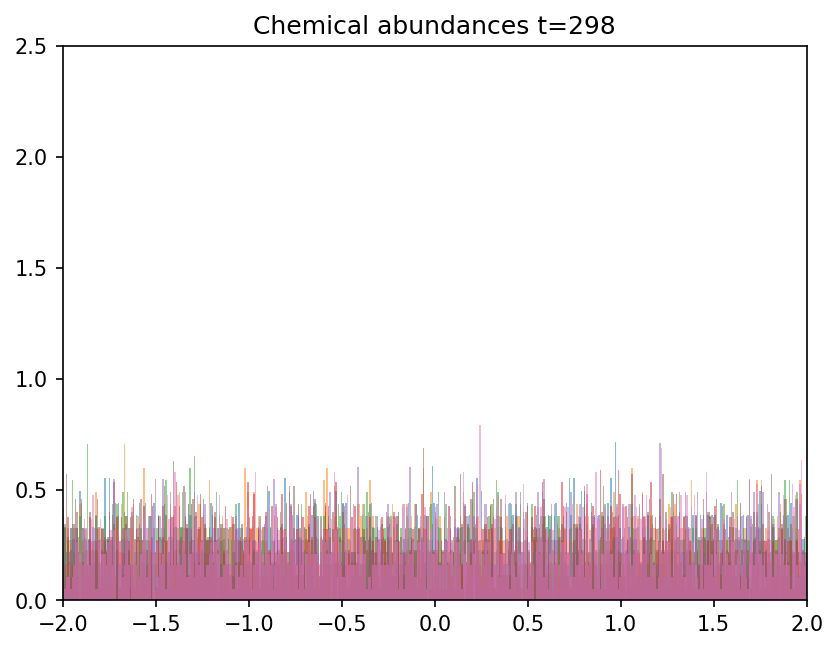

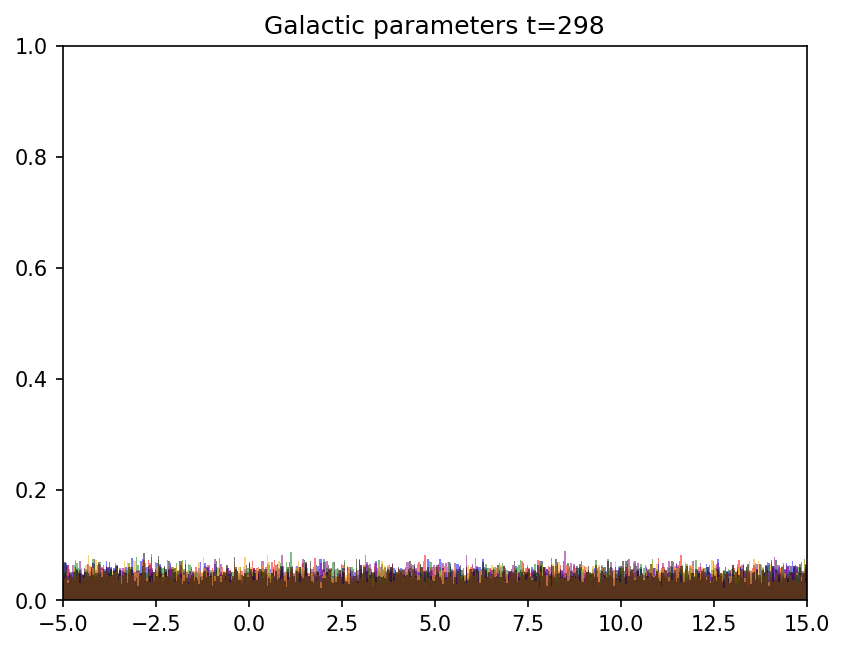

In [20]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)
color = ['red', 'blue', 'green', 'purple', 'orange', 'black']

def animate(i):
    data_t = simformer.forward_diffusion_sample(data[:,:6], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-5,15), density=True, alpha=0.5, color=color[n])
    plt.xlim([-5,15])
    plt.ylim([0,1])
    plt.title(f"Galactic parameters t={int(i)}")
   
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=299)

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('plots/theta_to_noise.gif', writer=writer)

plt.show()

In [ ]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

t = torch.linspace(0, 1, T)

def animate2(i):
    data_t = simformer.forward_diffusion_sample(data[:,7:], t[i])
    plt.cla()
    for n in range(data_t.shape[1]):
        plt.hist(data_t[:,n], bins=500, range=(-2,2), density=True, alpha=0.5)
    plt.xlim([-2,2])
    plt.ylim([0,2.5])
    plt.title(f"Chemical abundances t={int(i)}")

ani2 = matplotlib.animation.FuncAnimation(fig, animate2, frames=299) 

writer = matplotlib.animation.PillowWriter(fps=20,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani2.save('plots/x_to_noise.gif', writer=writer)

plt.show()

/Users/bguenes/miniconda3/envs/simformer/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
